In [1]:
import os
import csv
import tensorflow as tf  # 2.0
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.models import Model, Sequential
from keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Input, concatenate
from keras import optimizers
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from augmentedvolumetricimagegenerator.generator import customImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import math
import random
from sklearn.utils import shuffle


# Administrative items
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Where the file is located
path = r'C:\Users\jesse\OneDrive\Desktop\Research\PD\preprocessed_files\PD'
folder = os.listdir(path)
folder = sorted(folder)

Using TensorFlow backend.


In [2]:
# def generator():
    
#     num_batches = 8
#     batches = 0

#     for i in range(num_batches):
#         train = [1, 2, 3, 4, 5, 6, 7, 8]
        
#         history = train[i]*train[i]
        
#         batches += 1
#         yield history
#         if batches >= num_batches:
#             break

# history = generator()    
# for i in range(8):
#     print(next(history))

In [3]:
csv_path = r'C:\Users\jesse\OneDrive\Desktop\Research\PD\Montreal_Cognitive_Assessment__MoCA_.csv'

csv_read = pd.read_csv(csv_path)
patno = csv_read['PATNO']
moca = csv_read['MCATOT']

scores, hold = [], []
count = 0
for i in range(len(folder)):
    for j in range(len(patno)):
        if str(folder[i][5:9]) == str(patno[j]):
            count += 1
            hold.append(moca[j])
    scores.append(hold[count-1])
print(len(scores))

388


<function matplotlib.pyplot.show(*args, **kw)>

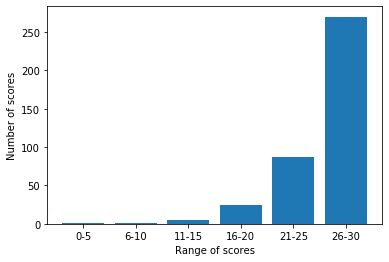

In [4]:
y = [0, 0, 0, 0, 0, 0]
for i in range(len(scores)):
    if scores[i] <= 5.:
        y[0] += 1
    elif scores[i] <= 10.:
        y[1] += 1
    elif scores[i] <= 15.:
        y[2] += 1
    elif scores[i] <= 20.:
        y[3] += 1
    elif scores[i] <= 25.:
        y[4] += 1
    elif scores[i] <= 30.:
        y[5] += 1

x = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30']        
plt.bar(x, y)
plt.xlabel('Range of scores')
plt.ylabel('Number of scores')
plt.show

In [5]:
img = []
for i in range(len(scores)):
    image = os.path.join(path, folder[i])
    image = nib.load(image)
    image = image.get_fdata()
    image = np.expand_dims(image, axis=3)
    img.append(image)

In [6]:
# x = np.asarray(img)
# y = np.asarray(scores)

# def create_batch(x, y, batch_size):

#     x, y = shuffle(x, y)
#     x_split, x_val, y_split, y_val = train_test_split(x, y, test_size=.05, shuffle=True)
#     x_batch, x_test, y_batch, y_test = train_test_split(x_split, y_split, test_size=.05, shuffle=True)
#     #print(x_batch.shape, x_val.shape, y_batch.shape, y_val.shape)
#     #x_split, x_test, y_split, y_test = train_test_split(x, y, test_size=.2, shuffle=True)
#     #x_train, x_val, y_train, y_val = train_test_split(x_split, y_split, test_size=.25, shuffle=True)
#     #print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)
    
#     x_train, y_train = [], []
#     num_batches = len(x_batch)//batch_size
#     for i in range(num_batches):
#         x_train.append([x_batch[0:batch_size]])
#         y_train.append([y_batch[0:batch_size]])
    
#     return x_train, y_train, x_val, y_val, x_batch, y_batch, x_test, y_test, num_batches

In [7]:
x = np.asarray(img)
y = np.asarray(scores)
x_split, x_test, y_split, y_test = train_test_split(x, y, test_size=.05, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_split, y_split, test_size=.05, shuffle=True)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(349, 96, 96, 96, 1) (19, 96, 96, 96, 1) (20, 96, 96, 96, 1) (349,) (19,) (20,)


In [8]:
batch_size = 2
input_size = (96, 96, 96, 1)

def build_model(input_size):
    model = Sequential()

    model.add(Conv3D(32, [3, 3, 3], padding='same', activation='relu',
                     input_shape=input_size))
    model.add(BatchNormalization())
    model.add(Conv3D(32, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(64, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(128, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(128, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(256, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(256, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(256, [3, 3, 3], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))

    opt = optimizers.Adam(lr=1e-5)
    model.compile(loss='msle', optimizer=opt, metrics=['accuracy'])
    
    return model

In [9]:
# #def augmentation(batch_size, epochs):
# epochs = 1

# model = build_model(input_size)
# x_train, y_train, x_val, y_val, x_batch, y_batch, x_test, y_test, num_batches = create_batch(x, y, batch_size)

# train_datagen = customImageDataGenerator(shear_range=0.2,
#                                          zoom_range=0.2,
#                                          horizontal_flip=True)
# val_datagen = customImageDataGenerator()


# validation_set = val_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)


# import psutil
# pid = os.getpid()
# py = psutil.Process(pid)
# memoryUse = py.memory_info()[0]/2.**30  # memory use in GB
# print('psutil memory use:', memoryUse)


# def generator(batch_size, epochs):
    
#     for e in range(epochs):
        
#         print('Epoch', e+1)
#         batches = 0
#         images_fitted = 0
        
#         for i in range(num_batches):
#             training_set = train_datagen.flow(x_train[i][0], y_train[i][0], batch_size=batch_size, shuffle=False)

#             images_fitted += len(x_train[i][0])
#             total_images = len(x_batch)
#             print('number of images used: %s/%s' % (images_fitted, total_images))
            
#             history = model.fit_generator(training_set,
#                                           steps_per_epoch = 1,
#                                           #callbacks = [earlystop], 
#                                           validation_data = validation_set,
#                                           validation_steps = 1)
#             model.load_weights('jesse_weights_13layers.h5')
#             batches += 1
#             yield history

#             if batches >= num_batches:
#                 break
    
#     return model
    
# def train_load_weights():
#     history = generator(batch_size, epochs)
#     for e in range(epochs):
#         for i in range(num_batches):
#             print(next(history))
#     model.save_weights('jesse_weights_13layers.h5')

In [10]:
# for i in range(1):
#     print('Run', i+1)
#     train_load_weights()

In [11]:
def augmentation(batch_size):

    model = build_model(input_size)
    
    train_datagen = customImageDataGenerator(shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)
    val_datagen = customImageDataGenerator()


    training_set = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
    validation_set = val_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)


#     weights_path = "weights"
#     num_weights = len(os.listdir(weights_path))

#     for i in range(num_weights+1):
#         weights = weights_path + '_%s' % (i+1) + '.h5'
#         if os.path.exists(weights) == False:
#             filepath = os.path.join(weights_path, weights)
#             break

#     checkpoint = ModelCheckpoint(filepath=filepath,
#                                  monitor = 'accuracy',
#                                  verbose=1,
#                                  save_best_only=True)

    #earlystop = EarlyStopping(monitor='loss', patience=10)


    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0]/2.**30  # memory use in GB
    print('memory use:', memoryUse)


    history = model.fit_generator(
                                  training_set,
                                  steps_per_epoch = len(x_train)//batch_size,
                                  epochs = 1,
                                  #callbacks = [earlystop, checkpoint],
                                  validation_data = validation_set,
                                  validation_steps = len(x_val)//batch_size
                                  )
    #model.load_weights('jesse_weights_nogen.h5')

    return model, history

model, history = augmentation(batch_size)
model.save_weights('jesse_weights_25layers.h5')

memory use: 9.670921325683594
Epoch 1/1
174/174 [==============================] - 5513s 32s/step - loss: 7.4593 - accuracy: 0.0000e+00 - val_loss: 3.9744 - val_accuracy: 0.0000e+00


In [12]:
def accuracy_score(y_pred, y_test):
    count = 0
    for i in range(len(y_test)):
        error = 1.
        if (y_pred[i] < y_test[i] + error) and (y_pred[i] > y_test[i] - error):
            count += 1
    accuracy = count/len(y_test)
    return accuracy


y_pred = model.predict(x_test, batch_size=batch_size)

for i in range(len(y_pred)):
    print('Predicted score:', y_pred[i], 'True score:', y_test[i])

accuracy_score(y_pred, y_test)

Predicted score: [3.2687185] True score: 27.0
Predicted score: [2.7948048] True score: 28.0
Predicted score: [3.379928] True score: 16.0
Predicted score: [3.14901] True score: 30.0
Predicted score: [3.118283] True score: 26.0
Predicted score: [3.1903248] True score: 19.0
Predicted score: [3.1342967] True score: 30.0
Predicted score: [3.3406675] True score: 26.0
Predicted score: [3.379216] True score: 26.0
Predicted score: [3.0711596] True score: 29.0
Predicted score: [2.730213] True score: 30.0
Predicted score: [3.2807553] True score: 29.0
Predicted score: [2.7042024] True score: 29.0
Predicted score: [2.7608876] True score: 21.0
Predicted score: [3.0992157] True score: 24.0
Predicted score: [2.9706674] True score: 24.0
Predicted score: [2.7927585] True score: 29.0
Predicted score: [2.7999232] True score: 26.0
Predicted score: [3.0408382] True score: 29.0
Predicted score: [3.40327] True score: 30.0


0.0

In [13]:
print(y_pred.min(), y_pred.max())

2.7042024 3.40327


<function matplotlib.pyplot.show(*args, **kw)>

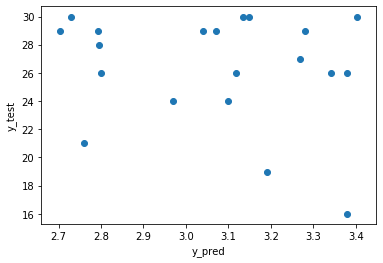

In [14]:
plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show

In [15]:
# weights_path = "weights"

# old_name = os.listdir(weights_path)[len(os.listdir(weights_path))-1]

# acc_val = str((history.history['accuracy'])[len(history.history['accuracy'])-1])[2:5]
# valacc_val = str((history.history['val_accuracy'])[len(history.history['val_accuracy'])-1])[2:5]
# new_name = 'weights_acc%s_val%s_ep%s' % (acc_val, valacc_val, epochs) + '.h5'

# old_file = os.path.join(weights_path, old_name)
# new_file = os.path.join(weights_path, new_name)
# print(old_file, new_file)
# os.rename(old_file, new_file)

Text(0.5, 1.0, 'Accuracy')

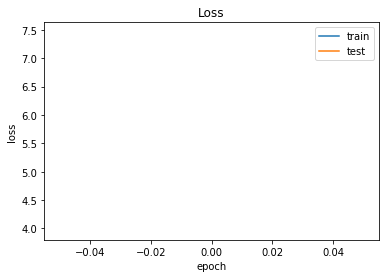

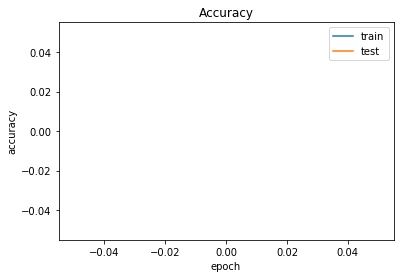

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(1)
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title('Loss')

plt.figure(2)
plt.plot(acc)
plt.plot(val_acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title('Accuracy')